In [27]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

df=pd.read_csv("./data/training_dataset.csv",low_memory=False)
df.match_date = df.match_date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

In [28]:
df

,player1_name,player1_atprank,player1_games,player1_wins,player1_loses,player1_indoors_wins,player1_indoors_loses,player1_outdoors_wins,player1_outdoors_loses,player2_name,...,player2_outdoors_wins,player2_outdoors_loses,match_date,match_location,match_tournament,match_court,match_surface,match_odd_player1,match_odd_player2,winner_player1
0,Harrison R.,481,272,117,155,16,17,101,138,Mager G.,...,21,28,2021-01-07,Delray Beach,Delray Beach Open,Outdoor,Hard,1.72,2.00,0
1,Korda S.,26,126,75,51,15,9,60,42,Kwon S.W.,...,41,49,2021-01-07,Delray Beach,Delray Beach Open,Outdoor,Hard,1.72,2.00,1
2,Paul T.,14,204,111,93,19,13,92,80,Nam J.S.,...,0,3,2021-01-07,Delray Beach,Delray Beach Open,Outdoor,Hard,1.12,6.00,1
3,Travaglia S.,1024,81,27,54,5,12,22,42,Kecmanovic M.,...,95,87,2021-01-07,Antalya,Antalya Open,Indoor,Hard,2.62,1.44,1
4,Bellucci T.,915,380,179,201,22,24,157,177,Monteiro T.,...,60,91,2021-01-07,Delray Beach,Delray Beach Open,Outdoor,Hard,3.00,1.36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7057,Tiafoe F.,10,303,158,145,24,23,134,122,Evans D.,...,106,111,2023-08-05,Washington,Citi Open,Outdoor,Hard,1.29,3.75,0
7058,Griekspoor T.,37,97,47,50,7,14,40,36,Fritz T.,...,179,129,2023-08-06,Washington,Citi Open,Outdoor,Hard,3.50,1.30,1
7059,De Minaur A.,19,272,161,111,30,19,131,92,Tsitsipas S.,...,215,94,2023-08-06,Los Cabos,Los Cabos Open,Outdoor,Hard,3.20,1.36,0
7060,Evans D.,30,251,124,127,18,16,106,111,Dimitrov G.,...,310,212,2023-08-06,Washington,Citi Open,Outdoor,Hard,3.20,1.36,1


In [29]:
df = df.dropna()
df.shape

(7029, 26)

In [47]:
from sklearn.model_selection import train_test_split

X = df[["player1_atprank", "player1_games", "player1_wins", "player1_loses", "player1_indoors_wins","player1_indoors_loses","player1_outdoors_wins","player1_outdoors_loses",
        "player2_atprank", "player2_games", "player2_wins", "player2_loses", "player2_indoors_wins","player2_indoors_loses","player2_outdoors_wins","player2_outdoors_loses",
        "match_date", "match_court", "match_odd_player1", "match_odd_player2"]]
y = df.winner_player1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)# shuffle=False)

In [48]:
from sklearn import preprocessing

X_train_filtered = X_train.drop("match_date",axis=1)
X_test_filtered = X_test.drop("match_date",axis=1)

#normalisation is useless for gradientboostingclassifier

# we encode match_court to binary
X_train_filtered = X_train_filtered.apply(preprocessing.LabelEncoder().fit_transform)
X_test_filtered = X_test_filtered.apply(preprocessing.LabelEncoder().fit_transform)

In [49]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.3,max_depth=1, random_state=0)
model = model.fit(X_train_filtered, y_train)

#cross_val_score(dtree, X_test, y_test, cv=10)

y_predict = model.predict(X_test_filtered)

accuracy_score(y_predict, y_test)

0.686344238975818

In [50]:
# ROI return of investment on all games

print("We bet 1€ on all test matches")
df_roi = X_test.copy()
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

money_invested=df_roi.shape[0]
print("money spent:", money_invested,"€")

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won,2) - money_invested,"€")

We bet 1€ on all test matches
money spent: 1406 €
money won: 1415.99 €
TOTAL: 9.990000000000009 €


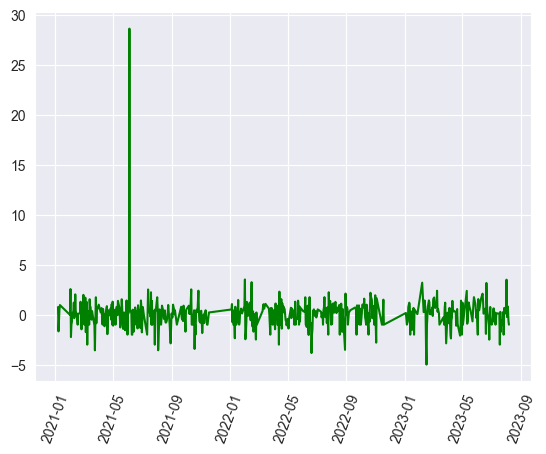

In [51]:
# on all games 
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.match_odd_player2
        else:
            money_won += row.match_odd_player1

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)

In [52]:
#only games where predict proba is > 0.8

y_predict_proba = model.predict_proba(X_test_filtered)


print("We bet 1€ on all test matches where proba score is > 0.9")
df_roi = X_test.copy()
df_roi["y_predict_proba"] = y_predict_proba[:,0]   #all rows, first column = prediction score for winner 1 
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

df_roi= df_roi.loc[(df_roi["y_predict_proba"]>0.9) | (df_roi["y_predict_proba"]<0.1)]

money_invested=df_roi.shape[0]

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money spent:", money_invested,"€")
print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won - money_invested, 2),"€")
print("ROI:", round(money_won*100/money_invested,2),"%")
                

We bet 1€ on all test matches where proba score is > 0.9
money spent: 113 €
money won: 119.39 €
TOTAL: 6.39 €
ROI: 105.65 %


C:\Users\chbou\AppData\Local\Temp\ipykernel_16072\3627483195.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in (df_roi[y_predict == y_test]).iterrows():


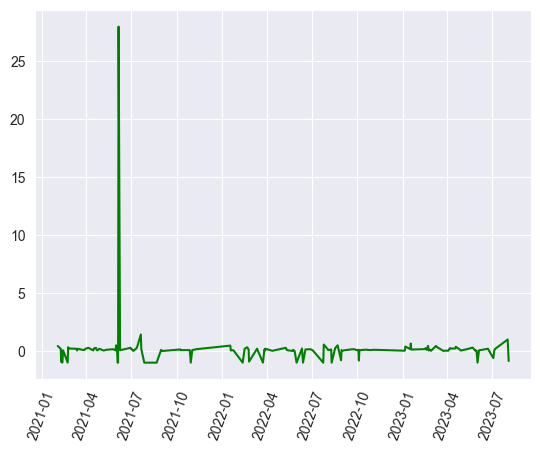

In [36]:
# on proba score > 0.9 (roi filtered from previous cell)
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.match_odd_player2
        else:
            money_won += row.match_odd_player1

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)

In [37]:
df_roi

,player1_atprank,player1_games,player1_wins,player1_loses,player1_indoors_wins,player1_indoors_loses,player1_outdoors_wins,player1_outdoors_loses,player2_atprank,player2_games,...,player2_indoors_loses,player2_outdoors_wins,player2_outdoors_loses,match_date,match_court,match_odd_player1,match_odd_player2,y_predict_proba,y_predict,y_test
84,528,288,130,158,6,19,124,139,185,2,...,0,0,2,2021-02-02,Outdoor,1.44,2.62,0.034606,1,1
178,185,2,0,2,0,0,0,2,25,303,...,7,184,101,2021-02-08,Outdoor,5.50,1.14,0.991865,0,0
198,19,500,346,154,60,31,286,123,69,150,...,14,48,68,2021-02-08,Outdoor,1.05,11.00,0.061688,1,1
227,25,379,234,145,31,29,203,116,97,215,...,26,60,103,2021-02-09,Outdoor,1.05,11.00,0.058925,1,0
209,5,390,264,126,49,32,215,94,188,869,...,94,356,284,2021-02-09,Outdoor,1.06,10.00,0.041440,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6704,113,159,78,81,19,18,59,63,108,99,...,6,41,50,2023-07-05,Outdoor,1.08,8.00,0.071075,1,1
6754,7,392,255,137,57,34,198,103,123,522,...,52,230,174,2023-07-07,Outdoor,1.20,4.50,0.075861,1,1
6991,140,3,0,3,0,1,0,2,144,21,...,2,8,8,2023-08-01,Outdoor,1.80,2.00,0.953828,0,0
7039,15,343,185,158,28,28,157,130,276,32,...,4,5,18,2023-08-03,Outdoor,1.14,5.50,0.053870,1,1


In [38]:
#indoor / outdoor semble avoir peu d'influence

In [45]:
#Ici on veut conserver uniquement les jouerus qui ont fait déja au moins 6 matchs en pro
df_roi= df_roi.loc[(df_roi["player1_games"]>6) & (df_roi["player2_games"]<6)]

money_invested=df_roi.shape[0]

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money spent:", money_invested,"€")
print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won - money_invested, 2),"€")
print("ROI:", round(money_won*100/money_invested,2),"%")
                

money spent: 12 €
money won: 14.21 €
TOTAL: 2.21 €
ROI: 118.42 %


C:\Users\chbou\AppData\Local\Temp\ipykernel_16072\2862464781.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in (df_roi[y_predict == y_test]).iterrows():


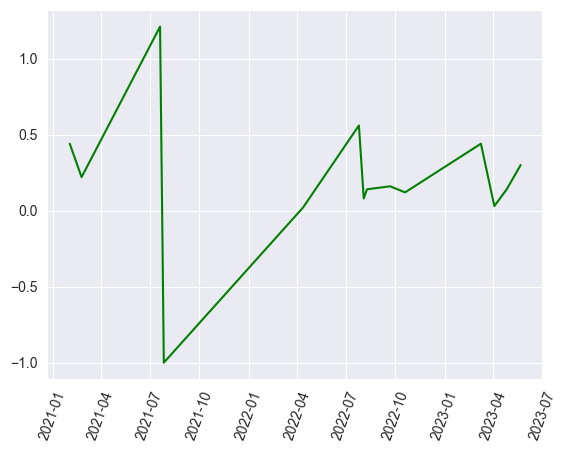

In [40]:
# on proba score > 0.9 (roi filtered from previous cell)
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.match_odd_player2
        else:
            money_won += row.match_odd_player1

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)

In [41]:
# Se limiter au joueur ayant un nombre minimum de parties augmentent grandement la fiabilité du modèle...
# ... mais réduit drastiquement le nombre de match à parier